In [144]:
import pandas as pd
import numpy as np
from pandas.plotting import scatter_matrix
from math import ceil
import matplotlib.pyplot as plt
from matplotlib import ticker
import sklearn
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC

# Data

## Load and preprocess data

In [145]:
DATA_PATH = './data/'

In [146]:
def check_male_female_abbreviations(X) :
    female_abbreviations = ['Miss.', 'Mrs.', 'Mme.', 'Ms.', 'Countess.']
    male_abbreviations = ['Master', 'Mr.', 'Rev.', 'Don.', 'Major.', 'Col.', 'Capt.', 'Jonkheer']

    abbreviations = female_abbreviations + male_abbreviations
    abbreviations = '|'.join(abbreviations)

    print(abbreviations)
    
    display(X.loc[~X['name'].str.contains(abbreviations)])

In [147]:
# Load and preprocess data

# Auxiliary features will be droped during preprocessing
auxiliary_features = ['name']
numerical_features = ['age', 'sibsp', 'parch', 'fare']
categorical_features = ['pclass', 'sex', 'embarked']

female_abbreviations = ['Miss.', 'Mrs.', 'Mme.', 'Ms.', 'Countess.']
male_abbreviations = ['Master', 'Mr.', 'Rev.', 'Don.', 'Major.', 'Col.', 'Capt.', 'Jonkheer']

def read_csv(type = 'train') :
    dataset = pd.read_csv('{}/{}.csv'.format(DATA_PATH, type))
    dataset.columns = dataset.columns.str.lower()
    
    return dataset

def get_training_features_labels() :
    training_data = read_csv('train')
    
    X_train = training_data.drop(columns=['survived'])
    X_train = X_train[numerical_features + categorical_features + auxiliary_features]
    
    y_train = training_data['survived']
    
    return X_train, y_train

class AgeTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X):        
        young_male_df = X.loc[X['name'].str.contains('Master.')]
        male_df = X.loc[(X['sex'] == 'male') & (~X['name'].str.contains('Master.'))]
        female_df = X.loc[(X['sex'] == 'female')]
        
        young_male_age_mean = young_male_df['age'].mean()
        male_age_mean = male_df['age'].mean()
        female_age_mean = female_df['age'].mean()
        
        X['age'] = X.apply(
            lambda row : row['age'] if not np.isnan(row['age']) else get_row_age_by_sex(row, male_age_mean, young_male_age_mean, female_age_mean),
            axis=1
        )
        
        return X[['age']]
    def get_feature_names_out(self, feature_names) :
        return ['age']
    
def get_row_age_by_sex(row, male_age_mean, young_male_age_mean, female_age_mean) :
    if row['sex'] == 'female' :
        return female_age_mean
    
    if ('Master.') in row['name'] :
        return young_male_age_mean 
    else :
        return male_age_mean
    
def get_preprocessor(scaler = 'standard') :
    numerical_transformer = Pipeline(
    steps=[
        ('imputer', SimpleImputer(strategy='median'))
        ]
    )
    
    if scaler == 'standard' :
        numerical_transformer.steps.append(['scaler', StandardScaler()])
    if scaler == 'minmax' :
        numerical_transformer.steps.append(['scaler', MinMaxScaler()])

    categorical_transformer = Pipeline(
        steps=[
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('encoder', OneHotEncoder(handle_unknown='ignore'))
            ]
        )
    
    age_transformer = AgeTransformer()

    age_transformer_features = ['age', 'sex', 'name']
    numerical_transformer_features = [x for x in numerical_features if x not in age_transformer_features]

    preprocessor = ColumnTransformer( [
        ('age_transformer', age_transformer, age_transformer_features),
        ('numerical_transformer', numerical_transformer, numerical_transformer_features),
        ('categorical_transformer', categorical_transformer, categorical_features),
    ], verbose_feature_names_out=False)
    
    return preprocessor

X_train, y_train = get_training_features_labels()
preprocessor = get_preprocessor(scaler='standard')

X_train = preprocessor.fit_transform(X_train)

X_test = read_csv('test')
X_test = preprocessor.transform(X_test)

## Visualize data

In [148]:
# Load preprocessed dataframe from X_train, y_train and a raw dataframe without changes

columns = np.array(preprocessor.get_feature_names_out())

X_df = pd.DataFrame(X_train, columns=columns)
y_df = pd.DataFrame(y_train, columns=['survived'])

df_preprocessed = pd.DataFrame.join(X_df, y_df)
df_raw = read_csv('train')

display(X_df.head())

,age,sibsp,parch,fare,pclass_1,pclass_2,pclass_3,sex_female,sex_male,embarked_C,embarked_Q,embarked_S
0,22.0,0.432793,-0.473674,-0.502445,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
1,38.0,0.432793,-0.473674,0.786845,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
2,26.0,-0.474545,-0.473674,-0.488854,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0
3,35.0,0.432793,-0.473674,0.420730,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
4,35.0,-0.474545,-0.473674,-0.486337,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0


In [149]:
# Visualize raw data

display(df_raw.head())
display(df_raw.describe())

print('{}\n'.format(df_raw['embarked'].value_counts()))
print('{}\n'.format(df_raw['sex'].value_counts()))

for column in df_raw :
    null_count = df_raw[column].isna().sum()
    
    if null_count > 0 :
        print("Amount of null values in {} column: {} ({:.3f}%)".format(column, null_count, null_count/len(df_raw)))

,passengerid,survived,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


,passengerid,survived,pclass,age,sibsp,parch,fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


embarked
S    644
C    168
Q     77
Name: count, dtype: int64

sex
male      577
female    314
Name: count, dtype: int64

Amount of null values in age column: 177 (0.199%)
Amount of null values in cabin column: 687 (0.771%)
Amount of null values in embarked column: 2 (0.002%)


In [150]:
# Visualize correlation matrix

df_preprocessed_corr_matrix = df_preprocessed.corr()['survived'].sort_values(ascending=False)

print('Preprocessed DF Correlation Matrix\n{}'.format(df_preprocessed_corr_matrix))

Preprocessed DF Correlation Matrix
survived      1.000000
sex_female    0.543351
pclass_1      0.285904
fare          0.257307
embarked_C    0.168240
pclass_2      0.093349
parch         0.081629
embarked_Q    0.003650
sibsp        -0.035322
age          -0.094318
embarked_S   -0.149683
pclass_3     -0.322308
sex_male     -0.543351
Name: survived, dtype: float64


In [151]:
def plot_stacked_bar(x, y1, y2, y1label = 'y1', y2label = 'y2', title = '', xlabel = '', ylabel = '', 
                     using_percentage = True, major_locator_range = -1, 
                     yaxis_visibility = False, xaxis_visibility = True,
                     xticks = [], yticks = [], figsize=(10, 8)) :
    fig, ax = plt.subplots(figsize=figsize)
    
    ax.bar(x, y1, color='cornflowerblue', edgecolor='dimgray', label=y1label, width=5)
    ax.bar(x, y2, bottom=y1, color='indianred', edgecolor='dimgray', label=y2label, width = 5)

    for c in ax.containers :
        if using_percentage :
            ax.bar_label(c, label_type='center', fmt='%.3f%%')
        else :
            ax.bar_label(c, label_type='center')
    
    if major_locator_range > 0 :
        ax.xaxis.set_major_locator(ticker.MultipleLocator(major_locator_range))
    
    ax.get_yaxis().set_visible(yaxis_visibility)
    ax.get_xaxis().set_visible(xaxis_visibility)
    
    if title != '' :
        ax.set_title(title)
        
    if xlabel != '' :
        ax.set_xlabel(xlabel)
        
    if ylabel != '' :
        ax.set_xlabel(ylabel)

    if xticks != [] :
        ax.set_xticks(x, xticks)
        
    if yticks != [] :
        ax.set_yticks(x, yticks)
     
    plt.legend()
    plt.show()

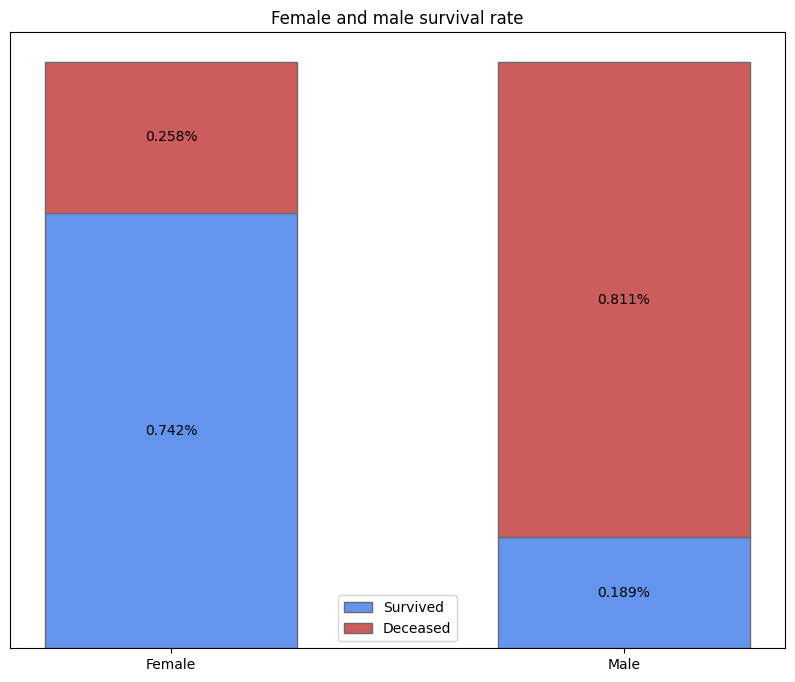

In [152]:
# Female and male survival rate comparison

def plot_female_male_survival() :
    female = df_preprocessed.loc[df_preprocessed['sex_female'] == 1]
    male = df_preprocessed.loc[df_preprocessed['sex_male'] == 1]

    female_survivor_count = len(female.loc[female['survived'] == 1])
    female_deceased_count = len(female.loc[female['survived'] == 0])
    
    male_survivor_count = len(male.loc[male['survived'] == 1])
    male_deceased_count = len(male.loc[male['survived'] == 0])

    x = [
        (1),
        (10)
    ]

    y1 = [
        (female_survivor_count / (len(female))),
        (male_survivor_count / (len(male)))
    ]
    
    y2 = [
        (female_deceased_count / (len(female))),
        (male_deceased_count / (len(male))),
    ]
    
    plot_stacked_bar(x, y1, y2, title='Female and male survival rate', y1label='Survived', y2label='Deceased', xaxis_visibility=True, xticks=['Female', 'Male'])
      
plot_female_male_survival()

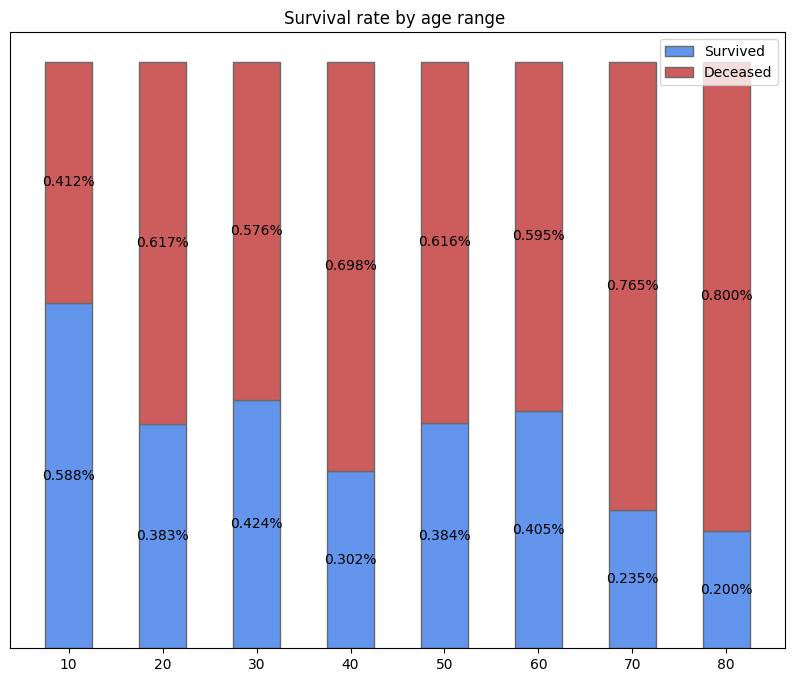

In [153]:
# Age distribution among survivors and deceased

def plot_age_range_survival() :
    age_range = 10

    using_percentage = True

    x = []
    y1 = []
    y2 = []

    age_survived = df_preprocessed[['age', 'survived']].sort_values(by='age')
    step = 1
    interval = [0]
    while len(interval) > 0 :        
        interval = age_survived.loc[(age_survived['age'] > age_range * (step - 1)) & (age_survived['age'] <= age_range * step)]
        
        if len(interval) == 0 : 
            break
        
        total = len(interval)
        survivors = len(interval.loc[interval['survived'] == 1])
        deceased = len(interval.loc[interval['survived'] == 0])
        
        x.append(age_range * step)
        y1.append(survivors / total if using_percentage else survivors)
        y2.append(deceased / total if using_percentage else deceased)
        
        step += 1

    plot_stacked_bar(x, y1, y2, y1label='Survived', y2label='Deceased', title='Survival rate by age range ', using_percentage=using_percentage, major_locator_range=age_range, figsize=(10, 8))
    
plot_age_range_survival()

# Models

## Training

In [174]:
def fit_predict_model(X_train, y_train, model, folds = 3, model_name = '', output_cross_val_scores = True) :
    model.fit(X_train, y_train)
    scores = cross_val_score(model, X_train, y_train, cv=folds)
    
    if output_cross_val_scores :
        if model_name != '' :
            print(model_name)
        
        print("Scores: {}".format(scores))
        print("Mean: {}".format(scores.mean()))
        print("Std: {}\n".format(scores.std()))
        
def randomized_search(estimator, params, n_iter = 100, cv=5, verbose=3, random_state=1, n_jobs=-1) :
    search = RandomizedSearchCV(estimator=estimator, param_distributions=params, n_iter=n_iter, cv=cv, verbose=verbose, random_state=random_state, n_jobs=n_jobs)
    search.fit(X_train, y_train)
    return search

def grid_search(estimator, params, cv=5, verbose=3, n_jobs=-1) :
    search = GridSearchCV(estimator=estimator, param_grid=params, scoring='accuracy', cv=cv, verbose=verbose, n_jobs=n_jobs)
    search.fit(X_train, y_train)
    return search

def display_search_results_overview(search_results, thresholds = None, order_by='mean_test_score', ascending=True) :
    
    display('Best estimator: {}'.format(search_results.best_params_))
    display('Best score: {}'.format(search_results.best_score_))

    if thresholds != None :
        df = pd.DataFrame(search_results.cv_results_)             
    
        for key in thresholds :
            if len(thresholds[key]) == 1 :
                df = df.loc[df[key] >= thresholds[key][0]]
            else :    
                df = df.loc[df[key] <= thresholds[key][0] if thresholds[key][1] == 'max' else df[key] >= thresholds[key][0]]
            
        df = df.sort_values(order_by, ascending=ascending)
        
        param_columns = []
        
        for column in df.columns :
            if 'param' in column :
                param_columns.append(column)
        
        score_columns = ['mean_test_score', 'std_test_score']
        
        df = df[score_columns + param_columns]
        
        display(df)

### KNN

In [ ]:
# KNN

knn = KNeighborsClassifier(n_neighbors=3, metric='manhattan')
fit_predict_model(X_train, y_train, knn, folds=5, model_name='KNN')

### Random Forest

#### Randomized Search

In [170]:
# RandomizedSearch

def rf_randomized_search_params(print_params = False) :
    n_estimators = [int(x) for x in np.linspace(100, 200, num=20)]
    max_features = ['sqrt', 'log2']
    max_depth = [int(x) for x in np.linspace(10, 100, num=20)]
    max_depth.append(None)
    min_samples_split = np.arange(2, 10, 2)
    min_samples_leaf = np.arange(2, 20, 2)
    bootstrap = [True]
    
    params = {
        'n_estimators': n_estimators,
        'max_features': max_features,
        'max_depth': max_depth,
        'min_samples_split': min_samples_split,
        'min_samples_leaf': min_samples_leaf,
        'bootstrap': bootstrap
    }
    
    if print_params :
        for param in params :
            display('{}: {}'.format(param, params[param]))
    
    rf = RandomForestClassifier()
    
    return rf, params

rf, params = rf_randomized_search_params(False)
rf_randomized_search_results = randomized_search(rf, params, n_iter=500)

Fitting 5 folds for each of 500 candidates, totalling 2500 fits


In [171]:
scores = {
    'mean_test_score': [0.822],  
}

display_search_results_overview(rf_randomized_search_results, scores, order_by='mean_test_score', ascending=False)

"Best estimator: {'n_estimators': 157, 'min_samples_split': 6, 'min_samples_leaf': 2, 'max_features': 'log2', 'max_depth': 90, 'bootstrap': True}"

'Best score: 0.835044881049526'

,mean_test_score,std_test_score,param_n_estimators,param_min_samples_split,param_min_samples_leaf,param_max_features,param_max_depth,param_bootstrap,params
459,0.835045,0.034584,157,6,2,log2,90,True,"{'n_estimators': 157, 'min_samples_split': 6, ..."
206,0.833928,0.031089,147,2,2,log2,33,True,"{'n_estimators': 147, 'min_samples_split': 2, ..."
466,0.833928,0.036332,147,8,2,sqrt,95,True,"{'n_estimators': 147, 'min_samples_split': 8, ..."
406,0.832810,0.034662,184,4,2,log2,66,True,"{'n_estimators': 184, 'min_samples_split': 4, ..."
116,0.832798,0.037370,126,8,2,log2,90,True,"{'n_estimators': 126, 'min_samples_split': 8, ..."
...,...,...,...,...,...,...,...,...,...
395,0.822692,0.027966,163,4,4,log2,10,True,"{'n_estimators': 163, 'min_samples_split': 4, ..."
160,0.822685,0.018855,184,6,6,sqrt,38,True,"{'n_estimators': 184, 'min_samples_split': 6, ..."
86,0.822685,0.022516,142,8,4,log2,38,True,"{'n_estimators': 142, 'min_samples_split': 8, ..."
361,0.822685,0.016344,136,6,4,sqrt,76,True,"{'n_estimators': 136, 'min_samples_split': 6, ..."


In [ ]:
scores = {
    'mean_test_score': [0.822],  
}

old_results = rf_randomized_search_results

display_search_results_overview(rf_randomized_search_results, scores, order_by='mean_test_score', ascending=False)

"Best estimator: {'n_estimators': 114, 'min_samples_split': 6, 'min_samples_leaf': 2, 'max_features': 'log2', 'max_depth': 186, 'bootstrap': True}"

'Best score: 0.8339275626137719'

,mean_test_score,std_test_score,param_n_estimators,param_min_samples_split,param_min_samples_leaf,param_max_features,param_max_depth,param_bootstrap,params
49,0.833928,0.035453,114,6,2,log2,186,True,"{'n_estimators': 114, 'min_samples_split': 6, ..."
93,0.833921,0.032908,478,4,4,sqrt,102,False,"{'n_estimators': 478, 'min_samples_split': 4, ..."
52,0.832798,0.034562,895,8,4,log2,116,False,"{'n_estimators': 895, 'min_samples_split': 8, ..."
3,0.832791,0.032140,583,4,4,log2,88,False,"{'n_estimators': 583, 'min_samples_split': 4, ..."
61,0.831687,0.032528,1000,4,2,sqrt,102,True,"{'n_estimators': 1000, 'min_samples_split': 4,..."
32,0.831680,0.028433,322,2,2,log2,32,True,"{'n_estimators': 322, 'min_samples_split': 2, ..."
88,0.831674,0.032807,1000,4,4,sqrt,144,False,"{'n_estimators': 1000, 'min_samples_split': 4,..."
60,0.831662,0.023476,166,4,4,log2,130,True,"{'n_estimators': 166, 'min_samples_split': 4, ..."
72,0.830576,0.036541,791,4,2,log2,102,True,"{'n_estimators': 791, 'min_samples_split': 4, ..."
90,0.829439,0.034171,62,2,2,log2,130,True,"{'n_estimators': 62, 'min_samples_split': 2, '..."


#### Grid Search

In [175]:
def rf_grid_search_params(print_params = False) :
    n_estimators = [int(x) for x in np.linspace(100, 200, num=20)]
    max_features = ['sqrt', 'log2']
    max_depth = [int(x) for x in np.linspace(10, 100, num=20)]
    max_depth.append(None)
    min_samples_split = np.arange(2, 10, 2)
    min_samples_leaf = np.arange(2, 20, 2)
    bootstrap = [True]
    
    params = {
        'n_estimators': n_estimators,
        'max_features': max_features,
        'max_depth': max_depth,
        'min_samples_split': min_samples_split,
        'min_samples_leaf': min_samples_leaf,
        'bootstrap': bootstrap
    }
    
    if print_params :
        for param in params :
            display('{}: {}'.format(param, params[param]))
    
    rf = RandomForestClassifier()
    
    return rf, params

rf, params = rf_grid_search_params(False)
rf_grid_search_results = grid_search(rf, params)

Fitting 5 folds for each of 30240 candidates, totalling 151200 fits


In [178]:
scores = {
    'mean_test_score': [0.822],  
}

display_search_results_overview(rf_grid_search_results, scores, order_by='mean_test_score', ascending=False)

pd.DataFrame(rf_grid_search_results.cv_results_).to_csv('./models/random_forest/grid_search.csv')

"Best estimator: {'bootstrap': True, 'max_depth': 71, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 6, 'n_estimators': 147}"

'Best score: 0.8417801770133702'

,mean_test_score,std_test_score,param_bootstrap,param_max_depth,param_max_features,param_min_samples_leaf,param_min_samples_split,param_n_estimators,params
18769,0.841780,0.036327,True,71,sqrt,2,6,147,"{'bootstrap': True, 'max_depth': 71, 'max_feat..."
7250,0.840644,0.028901,True,33,sqrt,2,6,152,"{'bootstrap': True, 'max_depth': 33, 'max_feat..."
18720,0.840644,0.033362,True,71,sqrt,2,2,100,"{'bootstrap': True, 'max_depth': 71, 'max_feat..."
25240,0.840625,0.034572,True,90,log2,2,6,100,"{'bootstrap': True, 'max_depth': 90, 'max_feat..."
10089,0.839527,0.035886,True,43,sqrt,2,2,147,"{'bootstrap': True, 'max_depth': 43, 'max_feat..."
...,...,...,...,...,...,...,...,...,...
28247,0.822660,0.015842,True,100,log2,6,2,136,"{'bootstrap': True, 'max_depth': 100, 'max_fea..."
28361,0.822660,0.015842,True,100,log2,8,6,105,"{'bootstrap': True, 'max_depth': 100, 'max_fea..."
12489,0.822660,0.016236,True,47,log2,8,2,147,"{'bootstrap': True, 'max_depth': 47, 'max_feat..."
20473,0.822654,0.015903,True,76,sqrt,8,8,168,"{'bootstrap': True, 'max_depth': 76, 'max_feat..."


In [242]:
# Best model found
rf = RandomForestClassifier(n_estimators=152, min_samples_split=6, min_samples_leaf=2, max_features='sqrt', max_depth=33, bootstrap=True)
fit_predict_model(X_train, y_train, rf, folds=15, model_name='Random Forest')
predictions = rf.predict(X_test)

Random Forest
Scores: [0.76666667 0.83333333 0.8        0.75       0.81666667 0.86666667
 0.94915254 0.88135593 0.79661017 0.83050847 0.83050847 0.77966102
 0.86440678 0.83050847 0.86440678]
Mean: 0.8306967984934087
Std: 0.04877789407589228



In [241]:
def output_test_csv(predictions) :
    df = pd.DataFrame(predictions, columns=['Survived'])
    
    test_df = pd.read_csv('./data/test.csv')
    
    test_df = test_df['PassengerId']
    
    test_df = pd.DataFrame.join(test_df, df)
    
    test_df[['PassengerId', 'Survived']].to_csv('./output.csv', index=False)
    
    return

output_test_csv(predictions)

### Decision Tree

#### Randomized Search

In [209]:
# RandomizedSearch

def dt_randomized_search_params(print_params = False) :
    splitter = ['best', 'random']
    max_depth = [int(x) for x in np.linspace(5, 100, num=15)]
    max_depth.append(None)
    min_samples_split = np.arange(2, 10, 2)
    min_samples_leaf = np.arange(2, 20, 2)
    min_weight_fraction_leaf = [x for x in np.linspace(0, 0.5, 300)]
    max_features = ['log2', None]
    max_leaf_nodes = [int(x) for x in np.linspace(5, 1000, num=20)]
    max_leaf_nodes.append(None)
    min_impurity_decrease = [x for x in np.linspace(0, 1, 100)]
    
    params = {
        'splitter': splitter,
        'max_depth': max_depth,
        'min_samples_split': min_samples_split,
        'min_samples_leaf': min_samples_leaf,
        'min_weight_fraction_leaf': min_weight_fraction_leaf,
        'max_features': max_features,
        'max_leaf_nodes': max_leaf_nodes,
        'min_impurity_decrease': min_impurity_decrease
    }
    
    if print_params :
        for param in params :
            display('{}: {}'.format(param, params[param]))
    
    dt = DecisionTreeClassifier()
    
    return dt, params

dt, params = dt_randomized_search_params(False)
dt_randomized_search_results = randomized_search(dt, params, n_iter=50000)

Fitting 5 folds for each of 50000 candidates, totalling 250000 fits


In [210]:
scores = {
    'mean_test_score': [0.78],  
}

display_search_results_overview(dt_randomized_search_results, scores, order_by='mean_test_score', ascending=False)

"Best estimator: {'splitter': 'best', 'min_weight_fraction_leaf': 0.011705685618729096, 'min_samples_split': 4, 'min_samples_leaf': 10, 'min_impurity_decrease': 0.0, 'max_leaf_nodes': 57, 'max_features': None, 'max_depth': 18}"

'Best score: 0.818209779674848'

,mean_test_score,std_test_score,param_splitter,param_min_weight_fraction_leaf,param_min_samples_split,param_min_samples_leaf,param_min_impurity_decrease,param_max_leaf_nodes,param_max_features,param_max_depth,params
42963,0.818210,0.027215,best,0.011706,4,10,0.0,57,None,18,"{'splitter': 'best', 'min_weight_fraction_leaf..."
30067,0.814852,0.028361,best,0.0,2,6,0.0,528,None,66,"{'splitter': 'best', 'min_weight_fraction_leaf..."
45716,0.813722,0.029812,best,0.001672,2,6,0.0,423,None,59,"{'splitter': 'best', 'min_weight_fraction_leaf..."
24635,0.812592,0.020372,best,0.0,2,2,0.0,423,log2,66,"{'splitter': 'best', 'min_weight_fraction_leaf..."
18090,0.811481,0.023148,random,0.006689,8,10,0.0,842,None,38,"{'splitter': 'random', 'min_weight_fraction_le..."
...,...,...,...,...,...,...,...,...,...,...,...
278,0.782242,0.021366,best,0.080268,4,16,0.0,214,log2,79,"{'splitter': 'best', 'min_weight_fraction_leaf..."
44741,0.781181,0.017948,random,0.078595,2,6,0.010101,790,log2,93,"{'splitter': 'random', 'min_weight_fraction_le..."
34311,0.781119,0.021844,best,0.202341,4,4,0.0,214,log2,18,"{'splitter': 'best', 'min_weight_fraction_leaf..."
27539,0.781119,0.037231,best,0.01505,6,12,0.030303,738,log2,25,"{'splitter': 'best', 'min_weight_fraction_leaf..."


#### Grid Search

In [211]:
# RandomizedSearch

def dt_grid_search_params(print_params = False) :
    splitter = ['best']
    max_depth = [int(x) for x in np.linspace(5, 100, num=15)]
    max_depth.append(None)
    min_samples_split = [4, 2]
    min_samples_leaf = np.arange(2, 10, 2)
    min_weight_fraction_leaf = [x for x in np.linspace(0, 0.1, 150)]
    max_features = ['log2', None]
    max_leaf_nodes = [int(x) for x in np.linspace(50, 600, num=30)]
    max_leaf_nodes.append(None)
    min_impurity_decrease = [0]

    params = {
        'splitter': splitter,
        'max_depth': max_depth,
        'min_samples_split': min_samples_split,
        'min_samples_leaf': min_samples_leaf,
        'min_weight_fraction_leaf': min_weight_fraction_leaf,
        'max_features': max_features,
        'max_leaf_nodes': max_leaf_nodes,
        'min_impurity_decrease': min_impurity_decrease
    }
    
    if print_params :
        for param in params :
            display('{}: {}'.format(param, params[param]))
    
    dt = DecisionTreeClassifier()
    
    return dt, params

dt, params = dt_grid_search_params(False)
dt_grid_search_results = grid_search(dt, params)

Fitting 5 folds for each of 1190400 candidates, totalling 5952000 fits


In [213]:
scores = {
    'mean_test_score': [0.78],  
}

display_search_results_overview(dt_grid_search_results, scores, order_by='mean_test_score', ascending=False)

pd.DataFrame(rf_grid_search_results.cv_results_).to_csv('./models/decision_tree/grid_search.csv')

"Best estimator: {'max_depth': 25, 'max_features': 'log2', 'max_leaf_nodes': 87, 'min_impurity_decrease': 0, 'min_samples_leaf': 6, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0006711409395973155, 'splitter': 'best'}"

'Best score: 0.8361935848345992'

,mean_test_score,std_test_score,param_max_depth,param_max_features,param_max_leaf_nodes,param_min_impurity_decrease,param_min_samples_leaf,param_min_samples_split,param_min_weight_fraction_leaf,param_splitter,params
226351,0.836194,0.041061,25,log2,87,0,6,2,0.000671,best,"{'max_depth': 25, 'max_features': 'log2', 'max..."
915011,0.835045,0.034217,86,log2,391,0,6,4,0.007383,best,"{'max_depth': 86, 'max_features': 'log2', 'max..."
1060956,0.833921,0.029252,100,log2,353,0,2,2,0.004027,best,"{'max_depth': 100, 'max_features': 'log2', 'ma..."
1118419,0.833902,0.011981,None,log2,87,0,2,4,0.012752,best,"{'max_depth': None, 'max_features': 'log2', 'm..."
248573,0.832766,0.030470,25,log2,448,0,2,2,0.015436,best,"{'max_depth': 25, 'max_features': 'log2', 'max..."
...,...,...,...,...,...,...,...,...,...,...,...
596173,0.780001,0.026603,59,log2,50,0,8,4,0.048993,best,"{'max_depth': 59, 'max_features': 'log2', 'max..."
237805,0.780001,0.016688,25,log2,277,0,2,2,0.036913,best,"{'max_depth': 25, 'max_features': 'log2', 'max..."
473428,0.780001,0.026840,45,log2,467,0,6,4,0.018792,best,"{'max_depth': 45, 'max_features': 'log2', 'max..."
675204,0.780001,0.032382,66,log2,125,0,6,2,0.036242,best,"{'max_depth': 66, 'max_features': 'log2', 'max..."


In [218]:
# Best model found
dt = DecisionTreeClassifier(max_depth=25, max_features='log2', max_leaf_nodes=87, min_impurity_decrease=0, min_samples_leaf=6, min_samples_split=2, splitter='best', min_weight_fraction_leaf=0.000671)
fit_predict_model(X_train, y_train, dt, folds=15, model_name='Decision Tree')

Decision Tree
Scores: [0.8        0.78333333 0.78333333 0.73333333 0.81666667 0.88333333
 0.88135593 0.84745763 0.77966102 0.77966102 0.79661017 0.77966102
 0.84745763 0.76271186 0.76271186]
Mean: 0.8024858757062147
Std: 0.04265059027142064



### Linear SVC

In [ ]:
# Linear SVC

X_train_custom, y_train_custom = get_training_features_labels()
preprocessor = get_preprocessor(scaler='minmax')
X_train_custom = preprocessor.fit_transform(X_train_custom, y_train)

linear_svc = LinearSVC(C=1, loss='hinge', max_iter=10000000, dual='auto')
fit_predict_model(X_train_custom, y_train, linear_svc, folds=5, model_name='Linear SVC')